<a href="https://colab.research.google.com/github/Priscille-Erulin/Classification-challenge/blob/main/Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [2]:
class Options:
    def __init__(self, batch_size, lr, b1, b2, dropout, n_classes, img_size, channels, latent_dim, n_epochs, sample_interval):
        self.batch_size = batch_size
        self.lr = lr # we'll forget about the decay factor for the time being
        self.b1 = b1
        self.b2 = b2
        self.dropout = dropout
        self.n_classes = n_classes
        self.img_size = img_size
        self.channels = channels
        self.latent_dim = latent_dim
        self.n_epochs = n_epochs
        self.sample_interval = sample_interval


In [75]:
# Parameters extracted from researsch
opt = Options(batch_size=100,
    lr=0.001,
    b1=0.5,
    b2=0.99,
    dropout=0.5,
    n_classes=10,
    img_size=32,
    channels=1,
    latent_dim=100,
    n_epochs = 200,
    sample_interval=400)

In [76]:
os.makedirs("images", exist_ok=True)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        # wdloss = wasserstein_loss(validity_real, validity_fake)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )


        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
          sample_image(n_row=10, batches_done=batches_done)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[Epoch 191/200] [Batch 412/600] [D loss: 0.207899] [G loss: 0.278615]
[Epoch 191/200] [Batch 413/600] [D loss: 0.235500] [G loss: 0.970759]
[Epoch 191/200] [Batch 414/600] [D loss: 0.161607] [G loss: 0.320718]
[Epoch 191/200] [Batch 415/600] [D loss: 0.138179] [G loss: 0.499537]
[Epoch 191/200] [Batch 416/600] [D loss: 0.149040] [G loss: 0.579790]
[Epoch 191/200] [Batch 417/600] [D loss: 0.185375] [G loss: 0.295520]
[Epoch 191/200] [Batch 418/600] [D loss: 0.162505] [G loss: 0.634970]
[Epoch 191/200] [Batch 419/600] [D loss: 0.116939] [G loss: 0.543825]
[Epoch 191/200] [Batch 420/600] [D loss: 0.118144] [G loss: 0.583110]
[Epoch 191/200] [Batch 421/600] [D loss: 0.102167] [G loss: 0.650567]
[Epoch 191/200] [Batch 422/600] [D loss: 0.138273] [G loss: 0.613069]
[Epoch 191/200] [Batch 423/600] [D loss: 0.154884] [G loss: 0.861076]
[Epoch 191/200] [Batch 424/600] [D loss: 0.207089] [G loss: 0.324447]
[Epoch 191/2

At first I had mode collapse, the generator outputed the same output no matter the label and the noise. In experimented using WassersteinLoss on the discriminator but without success: my discriminator improved to fast compared to the generator and the generator loss exploded.


In [66]:
# class WassersteinLoss(nn.Module):
#     def __init__(self):
#         super(WassersteinLoss, self).__init__()

#     def forward(self, output_real, output_fake):
#         return torch.mean(output_real - output_fake)

# # Create an instance of WassersteinLoss
# wasserstein_loss = WassersteinLoss()

In [86]:
# Save the trained model
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")

In [88]:
loaded_gen= Generator()
loaded_discr = Discriminator()

loaded_gen.load_state_dict(torch.load("generator_final.pth"))
loaded_discr.load_state_dict(torch.load("discriminator_final.pth"))

# Move models to GPU if available
if cuda:
    loaded_gen.cuda()
    loaded_discr.cuda()

# Set the models to evaluation mode
loaded_gen.eval()
loaded_discr.eval()

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=1034, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

Predicted digit: 9


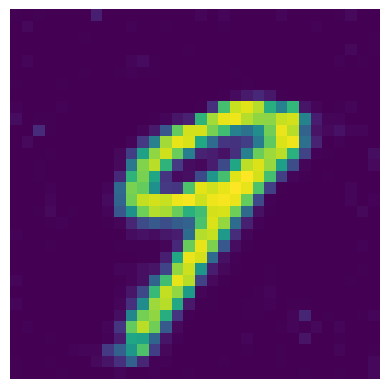

In [94]:
# show an image

# Sample noise and labels as generator input
z = Variable(FloatTensor(np.random.normal(0, 1, (1, opt.latent_dim))))
gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, 1)))

# Generate an image
gen_img = loaded_gen(z, gen_labels)

# Convert the generated image tensor to a NumPy array
gen_img_np = gen_img.detach().cpu().numpy()

# Display the PIL Image
print('Predicted digit:', gen_labels.item())
plt.imshow(gen_img_np.squeeze())
plt.axis('off')
plt.show()

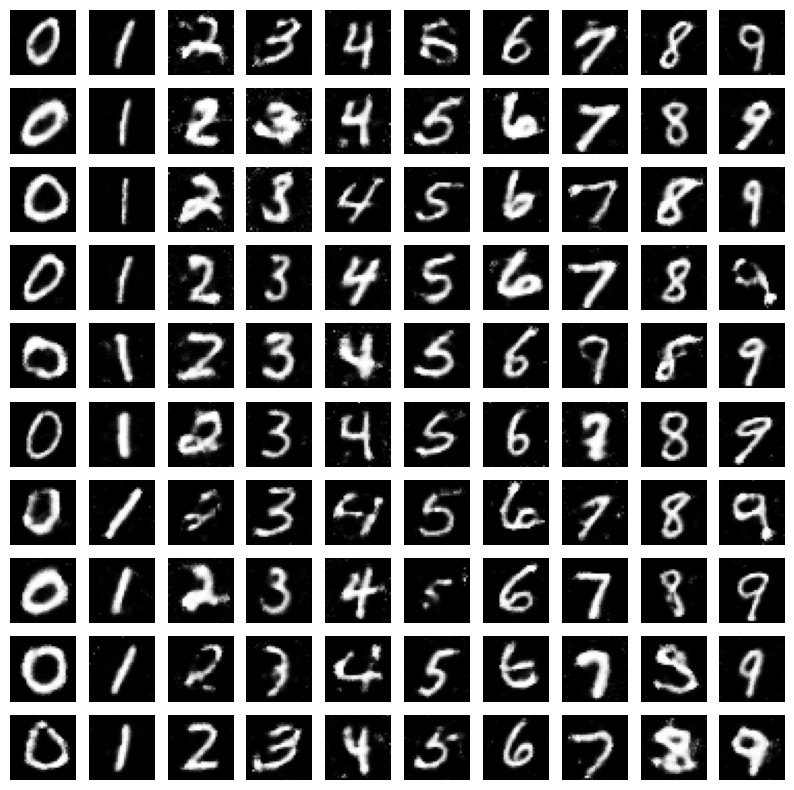

In [85]:
# Sample noise
z = Variable(FloatTensor(np.random.normal(0, 1, (10 ** 2, opt.latent_dim))))
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(10) for num in range(10)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)

fig, axs = plt.subplots(10, 10, figsize=(10, 10))

# Loop through the generated images and plot them
for i in range(10):
    for j in range(10):
        img_data = np.squeeze(gen_imgs[i * 10 + j].detach().cpu().numpy())
        axs[i, j].imshow(img_data, cmap='gray')
        axs[i, j].axis('off')

plt.show()

# Results

After 200 epochs:

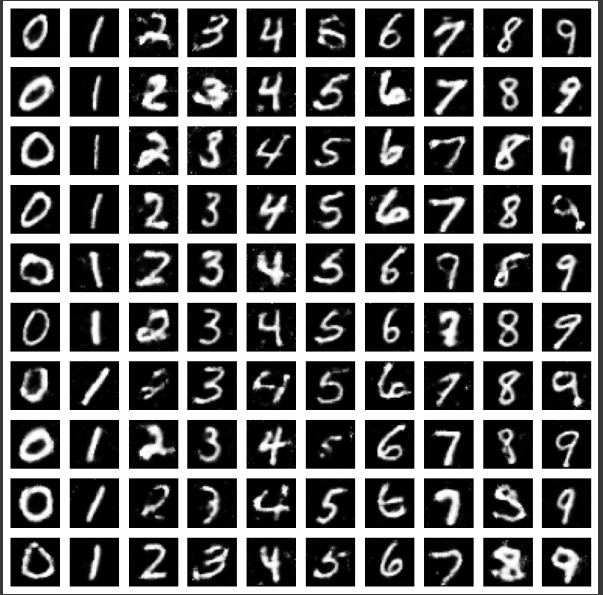